In [1]:
!nvidia-smi

Mon Aug 15 22:27:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   

In [2]:
import numpy as np
from tqdm.notebook import tqdm

In [5]:
import os
import re
from conllu import parse_incr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

files = {'train': ['ru_syntagrus-ud-train-a.conllu', 'ru_syntagrus-ud-train-b.conllu', 'ru_syntagrus-ud-train-c.conllu'],
         'test':  ['ru_syntagrus-ud-test.conllu'],
         'dev':   ['ru_syntagrus-ud-dev.conllu']}

labels = []
sentences = []
for data_type in files:
    for filename in files[data_type]: 
        with open(os.path.join('UD_Russian-SynTagRus', filename), encoding='utf-8') as f:
            parsed = parse_incr(f)
            for token_list in parsed:
                topic_name = token_list.metadata['sent_id'].split('.')[0]
                # уберём цифры из названий темы
                topic_name = re.sub(r'\d+', '', topic_name)
                sentence = ' '.join([token['form'] for token in token_list]).lower()
                labels.append(topic_name)
                sentences.append(sentence)

le = LabelEncoder()
ohe = OneHotEncoder()
ohe.fit(le.fit_transform(labels).reshape(-1, 1))

labels = np.array(labels)
sentences = np.array(sentences)

# оставляем только 1 пример

In [6]:
labels = labels[3:4]
sentences = sentences[3:4]
labels, sentences

(array(['Anketa'], dtype='<U53'),
 array(['однако стиль работы семена еремеевича заключался в том , чтобы принимать всех желающих и лично вникать в дело .'],
       dtype='<U1218'))

In [5]:
max_len = -1
lengths = []
for message in sentences:
    max_len = len(message.split()) if len(message.split()) > max_len else max_len
    lengths.append(len(message.split()))
max_len

19

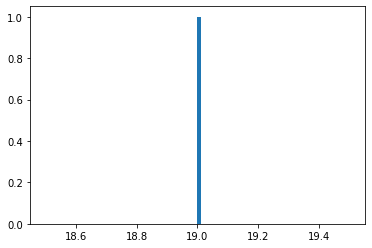

In [6]:
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()

In [7]:
TARGET_LEN = 52
EMBEDDING_SIZE = 200

# !!!ЭМБЕДИНГИ НЕ КАЧЕСТВЕННЫЕ, не сдавайся

In [8]:
import pickle
with open('word2vec_100.pkl', 'rb') as rf:
    W2V_100 = pickle.load(rf)
with open('fasttext_100.pkl', 'rb') as rf:
    FT_100 = pickle.load(rf)

In [9]:
W2V_100.wv.most_similar(positive='.'), FT_100.wv.most_similar('я')

([('накрахмаленных', 0.81927490234375),
  (';', 0.8096592426300049),
  ('рядовыми', 0.8064565062522888),
  ('чеченская', 0.7928946018218994),
  ('соцстранах', 0.7922433614730835),
  ('дымящих', 0.7861340641975403),
  ('одиночного', 0.7822094559669495),
  ('наркотикам', 0.7802185416221619),
  ('линейный', 0.7785296440124512),
  ('качественную', 0.7770684361457825)],
 [('он', 0.9201070070266724),
  ('уж', 0.8810179829597473),
  ('мыл', 0.8596895933151245),
  ('мышь', 0.8507342338562012),
  ('онф', 0.8464065194129944),
  ('мне', 0.8424739241600037),
  ('даешь', 0.838414192199707),
  ('он-лайн', 0.8318077921867371),
  ('ешь', 0.8273506760597229),
  ('да', 0.8267568349838257)])

In [10]:
def pad_sequences(sequence, target_len: int=20, embedding_size: int=300) -> np.array:
    sequence = np.array(sequence)
    if sequence.size == 0:
        # empty array
        current_length = 0
        return np.zeros((target_len, embedding_size))
    elif len(sequence.shape) == 1:
        sequence = np.array([sequence])
        current_length = 1
    else:
        current_length = sequence.shape[0]
        
    if current_length >= target_len:
        return sequence[-target_len:]
    
    # padding = np.random.uniform(size=(target_len - current_length, embedding_size))
    padding = np.zeros((target_len - current_length, embedding_size))
    return np.concatenate((padding, sequence), axis=0)

In [11]:
from tqdm.notebook import tqdm
def vectorize_sentence(sentence):
    vec = []
    for token in sentence.split():
        tkn_vec = np.concatenate((W2V_100.wv[token], FT_100.wv[token]), axis=0)
        vec.append(tkn_vec)
    return pad_sequences(vec, target_len=TARGET_LEN, embedding_size=EMBEDDING_SIZE)

In [12]:
RANDOM_DIM = 100


class DataGenerator():
    def __init__(self, labels, sentences, batches_per_epoch, batch_size):
        self.train_sentences = sentences
        self.train_labels = labels
        self.batches_per_epoch = batches_per_epoch
        self.batch_size = batch_size
    
    @staticmethod
    def rand_norm(npoints=1, ndim=RANDOM_DIM):
        rand_vec = np.random.normal(0, 1, size=[npoints, ndim])
        return rand_vec

    def __len__(self):
        return self.batches_per_epoch

    def batch(self):
        rand_sentences_indexes = np.random.randint(0, self.train_sentences.shape[0], size=self.batch_size)
        sent_batch = np.array([vectorize_sentence(sent) for sent in self.train_sentences[rand_sentences_indexes]])
        labels_batch = ohe.transform(le.transform(self.train_labels[rand_sentences_indexes]).reshape(-1, 1)).todense()
        return sent_batch, labels_batch

    def __iter__(self):
        for b in tqdm(range(self.batches_per_epoch), leave=False):
            yield self.batch()

    def rand_batch(self):
        rand_vec = self.rand_norm(self.batch_size)
        # for training generator with label
        rand_labels = np.random.randint(0, len(le.classes_), size=[self.batch_size])
        rand_labels = ohe.transform(rand_labels.reshape(-1, 1)).todense()
        return (rand_vec, rand_labels)

    
np.random.seed(42)
sent_indexes = np.random.randint(0, len(sentences), size=1)
MESSAGES_FROM_DATASET = [sentences[sent_indexes], labels[sent_indexes]]
FIXED_NOISE = [DataGenerator.rand_norm(1), ohe.transform(le.transform(labels[sent_indexes]).reshape(-1, 1)).todense()]
MESSAGES_FROM_DATASET

[array(['однако стиль работы семена еремеевича заключался в том , чтобы принимать всех желающих и лично вникать в дело .'],
       dtype='<U1218'),
 array(['Anketa'], dtype='<U53')]

# GENERATOR

(3, 52, 200)


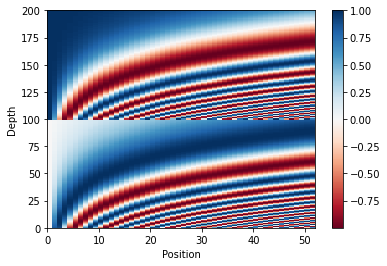

In [13]:
import tensorflow as tf

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(50, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def give_pe(batch_size, position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # angle_rads = angle_rads[np.newaxis, ...]

    return tf.constant([angle_rads for _ in range(batch_size)])

b, n, d = 3, 52, 200
pos_encoding = give_pe(b, n, d)

print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [25]:
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np

def make_generator(complexity=180):
    alpha = 0.2
    complexity = int(complexity)
    
    random_vector = keras.layers.Input(shape=[RANDOM_DIM])
    labels = keras.layers.Input(shape=[len(le.classes_)])
    
    X = keras.layers.Concatenate()([random_vector, labels])
    
    # layer 1
    X = keras.layers.Dense(
        TARGET_LEN//2//2*complexity,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Reshape((TARGET_LEN//2//2, complexity))(X)
    
    #layer 2 (None, 13, complexity)
    X = keras.layers.Conv1DTranspose(
        filters=complexity//2,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    #layer 3 (None, 13, complexity/2)
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=2,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    #layer 4 (None, 26, complexity/2)
    pe = K.tile(give_pe(1, 26, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=2,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    
    #layer 5 (None, 52, complexity)
    pe = K.tile(give_pe(1, 52, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    #layer 6 (None, 52, complexity)
    pe = K.tile(give_pe(1, 52, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    
    #layer 6 (None, 52, complexity)
    pe = K.tile(give_pe(1, 52, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    
    #layer 6 (None, 52, complexity)
    pe = K.tile(give_pe(1, 52, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    
    
    #layer 7 (None, 52, complexity)
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    X = keras.layers.Dense(EMBEDDING_SIZE)(X)
    
    model = keras.models.Model(inputs=[random_vector, labels], outputs=X)
    model.compile(
        loss='binary_crossentropy',
        metrics=['acc'],
        optimizer='sgd'
    )
    model.summary()
    return model
generator = make_generator()
generated_from_noise = generator(FIXED_NOISE)
generated_from_noise.shape

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 579)]        0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 679)          0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2340)         1591200     concatenate_6[0][0]        

TensorShape([1, 52, 200])

In [26]:
from scipy.spatial.distance import cosine


def distance_to_that_message(generated_vec):
    that_message_vec = vectorize_sentence(MESSAGES_FROM_DATASET[0][0])
    return np.mean([cosine(a, b)  for a, b in zip(generated_vec, that_message_vec)])


def message_recovery_with_metric(vector: np.ndarray):
    assert len(vector.shape) == 2
    tokens = []
    metric = []
    vector = vector.numpy()
    for token_vec in vector:
        w2v = token_vec[:100]
        token = W2V_100.wv.most_similar([w2v])[0][0]
        tokens.append(token)
        
        metric.append(cosine(token_vec[100:], FT_100.wv[token]))
    return ' '.join(tokens[-40:]), np.mean(metric), distance_to_that_message(vector)



for example in generated_from_noise:
    print(message_recovery_with_metric(example))

('постсталинское мщения мщения мщения зацикливаться зацикливаться зацикливаться постсталинское постсталинское постсталинское постсталинское постсталинское популяризовать популяризовать задаваемая печного зацикливаться осекся осекся переиздании иллюзорности одобрил сплюнул пересказ сжёг военкомате сторонке пометки ввяжемся навело социетальная смущал смущал тюремным тюремным тюремным шишками гематология гематология гематология', 0.9489196486672602, 0.34221372895771535)


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


# DISCRIMINATOR

In [27]:
def optimizer():
    return tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [28]:
def make_discriminator(complexity=480):
    complexity = int(complexity)
    alpha = 0.2
    drop_rate = 0.2
    inp = keras.layers.Input(shape=(TARGET_LEN, EMBEDDING_SIZE))
    X = inp
    
    #layer 1
    X = keras.layers.Conv1D(
        filters=complexity//2,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    #layer 2
    X = keras.layers.Conv1D(
        filters=complexity//3,
        kernel_size=3,
        padding='same',
        strides=2,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    
    #layer 2
    X = keras.layers.Conv1D(
        filters=complexity//3,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    #layer 2
    X = keras.layers.Conv1D(
        filters=complexity//3,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    
    #layer 3
    X = keras.layers.Conv1D(
        filters=complexity//4,
        kernel_size=3,
        padding='same',
        strides=2,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    #layer 4
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(complexity)(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    #layer 5
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(complexity//2)(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    # 6 layer
    X_real_fake = keras.layers.Dense(1, activation='sigmoid', name='real_fake')(X)
    # 6 layer
    X_labels = keras.layers.Dense(len(le.classes_), activation='softmax', name='labels')(X)
    
    model = keras.models.Model(inputs=inp, outputs=[X_real_fake, X_labels], name='discriminator')
    model.compile(loss={'real_fake': 'binary_crossentropy', 'labels': 'categorical_crossentropy'},
                  loss_weights={'real_fake':1, 'labels': 0.01},
                  optimizer=optimizer(),
                  metrics={'real_fake':'acc'})
    model.summary()
    return model

discriminator = make_discriminator()
discriminator(generated_from_noise)

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 52, 200)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 52, 240)      144240      input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_32 (LeakyReLU)      (None, 52, 240)      0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 52, 240)      0           leaky_re_lu_32[0][0]             
______________________________________________________________________________________

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.52095884]], dtype=float32)>,
 <tf.Tensor: shape=(1, 579), dtype=float32, numpy=
 array([[0.0016808 , 0.00181077, 0.00173999, 0.00169078, 0.00168576,
         0.00182769, 0.00186872, 0.00165469, 0.0016948 , 0.0017825 ,
         0.0015973 , 0.00162523, 0.0017188 , 0.00159832, 0.00162912,
         0.00176302, 0.00176882, 0.00156135, 0.00165922, 0.00171773,
         0.00181006, 0.00175211, 0.00183623, 0.00169222, 0.00167707,
         0.00182416, 0.00178263, 0.00171647, 0.00165974, 0.00174551,
         0.00182021, 0.00183284, 0.0016853 , 0.00184541, 0.00170293,
         0.00182482, 0.00172625, 0.00167222, 0.00169509, 0.00183469,
         0.00173875, 0.00161261, 0.00176239, 0.0018268 , 0.00173547,
         0.00172552, 0.0015967 , 0.00196639, 0.0016428 , 0.00181782,
         0.00165268, 0.00164062, 0.00182032, 0.00166522, 0.00168533,
         0.00174205, 0.00162216, 0.00164204, 0.00189881, 0.00167857,
         0.00178085, 0.00157881, 0

# BUILDING GAN

In [29]:
def make_gan(discriminator, generator):   
    noise = generator.inputs
    texts = generator(noise)
    real_vs_fake_and_label = discriminator(texts)
    gan = keras.models.Model(inputs=noise, outputs=real_vs_fake_and_label)
    # make discrimator not trainable before compile
    # because GAN training is training of generator
    discriminator.trainable = False  
    gan.compile(
        loss={
            'discriminator': 'binary_crossentropy',
            'discriminator_1': 'categorical_crossentropy',
        },
        loss_weights={'discriminator':1, 'discriminator_1': 0.01},
        optimizer=optimizer(),
        metrics={'discriminator':'acc'})
    discriminator.trainable = True
    gan.summary()
    return gan
gan = make_gan(discriminator, generator)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 579)]        0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 52, 200)      2863910     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
discriminator (Functional)      [(None, 1), (None, 5 1475740     model_2[0][0]              

# save and load

In [31]:
def save_models():
    discriminator.save('models/discriminator')
    generator.save('models/generator')
    gan.save('models/gan')
#  save_models()

INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


In [20]:
def load_models():
    discriminator = keras.models.load_model('models/discriminator')
    generator = keras.models.load_model('models/generator')
    gan = keras.models.load_model('models/gan')
load_models()

# final logic check

In [32]:
gan(FIXED_NOISE)[0]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.52095884]], dtype=float32)>

In [33]:
discriminator(generator(FIXED_NOISE))[0][0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.52095884], dtype=float32)>

# train

In [34]:
generator_acc_follow = []
generator_accuracy_cumulative = 0.5
discriminator_accuracy_cumulative = 0.5
loss_cumulative = 1
BATCH_SIZE = 128
data = DataGenerator(labels, sentences, batches_per_epoch=100, batch_size=BATCH_SIZE)

for epoch in range(300):
    print()
    generated_from_noise = generator(FIXED_NOISE)
    for example in generated_from_noise:
        print(message_recovery_with_metric(example))
    # save_models()

    for sent_batch, labels_batch in data:
        ##########################
        # discriminator training #
        ##########################
        noise = data.rand_batch()
        generated_texts = generator(noise)
        # X
        X = np.concatenate([sent_batch, generated_texts])
        # target valuest smoothing
        y_real = np.random.uniform(0.8, 1, size=[BATCH_SIZE])
        y_real = np.ones((BATCH_SIZE,))
        y_fake = np.random.uniform(0, 0.2, size=[BATCH_SIZE])
        y_fake = np.zeros((BATCH_SIZE,))
        # Y
        y_real_fake = np.concatenate([y_real, y_fake])
        y_labels = np.concatenate([labels_batch, np.zeros((BATCH_SIZE, len(le.classes_)))]) 
        
#         print(discriminator.train_on_batch(X, [y_real_fake, np.array(y_labels)]))
        discriminator.trainable = True
        loss, _, _, accuracy = discriminator.train_on_batch(X, [y_real_fake, np.array(y_labels)])
        # print('1', loss, accuracy, discriminator(sent_batch)[0])
        discriminator_accuracy_cumulative = 0.99 * discriminator_accuracy_cumulative + 0.01 * accuracy
        generator_accuracy_cumulative = 1 - discriminator_accuracy_cumulative
        
        ######################
        # generator training #
        ######################
        discriminator.trainable = False
        while True:
            noise = data.rand_batch()
            # target values
    #         y_real_fake = np.random.uniform(0.9, 1.0, size=[BATCH_SIZE])
            y_real_fake = np.ones((BATCH_SIZE,))

            # train GAN and save accuracy to array
    #         print(gan.train_on_batch(noise, [y_real_fake, noise[1]]))

            loss, _, _, accuracy = gan.train_on_batch(noise, [y_real_fake, noise[1]])
            accuracy = tf.math.reduce_mean(gan(noise)[0])
            # print('3', loss, accuracy)

            generator_accuracy_cumulative = 0.99 * generator_accuracy_cumulative + 0.01 * accuracy
            discriminator_accuracy_cumulative = 1 - generator_accuracy_cumulative
            print( 
                round(float(loss), 2),
                round(float(generator_accuracy_cumulative), 2),
                round(float(discriminator_accuracy_cumulative), 2),
                end='\r',
            )
            if generator_accuracy_cumulative > 0.5:
                break
#     print()
#     if epoch%10==0:
#         generated_from_noise = generator(FIXED_NOISE)
#         for example in generated_from_noise:
#             print(message_recovery_with_metric(example))
        


('постсталинское мщения мщения мщения зацикливаться зацикливаться зацикливаться постсталинское постсталинское постсталинское постсталинское постсталинское популяризовать популяризовать задаваемая печного зацикливаться осекся осекся переиздании иллюзорности одобрил сплюнул пересказ сжёг военкомате сторонке пометки ввяжемся навело социетальная смущал смущал тюремным тюремным тюремным шишками гематология гематология гематология', 0.9489196486672602, 0.34221372895771535)


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

0.39 0.5 0.5511
('карательных канэ горшкову обитаема канэ канэ где-либо обитаема где-либо нетерпим где-либо обитаема где-либо канэ где-либо нетерпим электроплиты космичности впитывал собянину парашют однако mori соединена модернисты дискотеки формируемся в том , чтобы плюсами всех бытовому и кабинетные киркуке в дело выпихивают', 0.7472433150710108, 0.11691260103563851)


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

1.17 0.5 0.55110.5 0.50.46 0.54


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


('норманистами норманистами норманистами норманистами норманистами норманистами дополнительности норманистами дополнительности норманистами дополнительности норманистами дополнительности норманистами проведенную человеков проведенную человеков карбюратор сбегали возродившись однако ещё работы святые аптека скафандрах в том , чтобы перекрывать всех витражи и двинемся богопротивные в дело .', 0.7418851704748634, 0.05207081470439764)
INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

0.38 0.5 0.5510.580.52 0.57


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


('вельмож стремлениями вельмож стремлениями вельмож стремлениями стремлениями стремлениями стремлениями стремлениями стремлениями стремлениями вельмож волокнам придерживаясь волокнам согнешь индокитае фейерверки были тоталитарность однако достойное работы чьи ловок гиря в том , чтобы выживет всех падений и глубокий матовый в дело .', 0.6368990467968755, 0.03557897145772134)
INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

0.34 0.5 0.5510.46 0.540.41 0.59


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


('бумажонки бумажонки бумажонки бумажонки бумажонки бумажонки бумажонки бумажонки бумажонки гостим бумажонки гостим бумажонки превознести бумажонки обустроено общенациональным устраивало индокитае индокитае электропоездов однако разрушенных работы твоего неприемлемые властвовало в том , чтобы выживет всех коварнее и стыкуется геродот в дело .', 0.6422908862228863, 0.026871514523274322)
INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

0.33 0.5 0.5110.46 0.540.42 0.58 0.52


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


('перекрестках спиритуальный перекрестках гостиниц перекрестках спиритуальный перекрестках спиритуальный перекрестках гостиниц перекрестках спиритуальный гостиниц спиритуальный обдумала спиритуальный тоталитарному написавшие косынка сопоставимость к-159 однако библиограф работы выпускниками осматриваться сводку в том , чтобы молдавию всех инвестировал и отреагировала пристройками в дело .', 0.9237845327991706, 0.0326302712050682)
INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

1.06 0.5 0.5510.530.46 0.54
('первичка металликов обрываясь металликов уважало металликов первичка металликов нерефлексивные уважало уважало уважало уважало уважало металликов металликов металликов энциклике печатанию исключена памфлет однако раскрываются работы возбужденными пилотаж юморить в том , чтобы резервуары всех неподвижные и счастье штрафстоянке в дело .', 0.8182342254138069, 0.028265164501573053)


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

1.09 0.5 0.5510.50.540.690.67


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


('халявщики менуэта халявщики менуэта халявщики менуэта халявщики менуэта халявщики менуэта халявщики менуэта халявщики менуэта халявщики менуэта задремала менуэта задремала подложить пишутся однако противопоказание работы публицист шашлыки пожелало в том , чтобы теплоноситель всех легислатуры и ответа перескажем в дело .', 0.6337894591717765, 0.04828426416161209)
INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

1.13 0.5 0.5510.44 0.560.630.37 0.630.630.36 0.64 0.640.640.36 0.640.36 0.640.36 0.640.36 0.640.640.37 0.630.620.62 0.620.38 0.620.38 0.620.61 0.610.39 0.610.610.61 0.60.39 0.610.60.6 0.60.4 0.60.60.580.570.550.41 0.590.530.49 0.51 0.510.60.580.570.520.48 0.52
('существуем в существуем в существуем в существуем в позавидовать в позавидовать в позавидовать в существуем в биографам в практикуется крайней стрелявшего однако душевая работы разливательной предопределила шлифовалась в том , чтобы индивидуумы всех гауляйтеры и предложу полубог в дело .', 0.5352328336582735, 0.09237029037593975)


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

0.13 0.5 0.55110.510.5 0.50.50.5 0.50.5 0.50.5 0.50.5 0.50.50.670.32 0.680.32 0.680.660.35 0.650.38 0.620.550.520.48 0.520.510.21 0.79


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


('выменять выменять выменять выменять выменять выменять выменять выменять выменять выменять выменять выменять выменять выменять выменять выменять выменять клерков сарванлар отвернет придвинулись однако уменьшало работы медсестра дежурил заявились в том очередь чтобы стопорится всех аделфи и потрясали смыслах в выращивала .', 0.6778869948421533, 0.11134077890849355)
INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

1.56 0.5 0.5512


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


('возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться возвратиться мягкосердечен мягкосердечен падуанский стульям однако подзащитному работы эспаньолкой ветрогенератором уэйтстилл в том , чтобы живется всех мишиного и выдержал выпивши в дело кондоминиумов', 0.6629181352372353, 0.06711680897333741)
INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

6.44 0.5 0.551260.780.910.13 0.87
('неутешительны объединяемые неутешительны объединяемые неутешительны объединяемые неутешительны объединяемые неутешительны объединяемые неутешительны объединяемые неутешительны объединяемые неутешительны объединяемые неутешительны объединяемые неутешительны объединяемые неутешительны однако сложа проката метисные ликования адлера в финальное прикасался чтобы попрекать всех фельдшерского и эмигрантский обрусевшие в телезависимость daewoo', 0.6672365878923581, 0.14798374363196087)


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

469.28 0.51 0.49520.50.28 0.720.28 0.720.75 0.910.14 0.860.710.96
('водородная поправиться водородная поправиться водородная поправиться водородная поправиться водородная поправиться пуститься поправиться пуститься поправиться пуститься поправиться антинорманистами поправиться пуститься поправиться норманистами однако возницами распространились луанде миропорядке боярской в тульской синхронизовались смутные перекосив многих работающее и армянском 211-ю в одноклассника полиграф', 0.8438753083106488, 0.14221322110994897)


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

3393919.0 0.54 0.46606 0.940.06 0.940.950.990.37 0.63
('изнуряющей изнуряющей письменно письменно конечную изнуряющей изнуряющей изнуряющей изнуряющей письменно письменно письменно вылечить письменно излишних излишних детальная изнуряющей резке программированием оппозиционности кончаются шайбу происки постиракский пургу дулаг канадцы отрапортовать лифтостроительный постигаем кривизны отрапортовать подтвержденные чешет моментальных мятый канадцы отрапортовать подтвержденные', 0.7162887225858867, 0.26129904712175767)


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

12517683.0 0.54 0.467


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


('передаточным грубоватый передаточным грубоватый передаточным выдвигающий передаточным выяснят передаточным выяснят передаточным выяснят передаточным человечны молчу человечны иогеля кнопок миллиардером добродушно tsmc фетиш энергетикам иве обнажают высвобождают бываешь кунцевской колоколов обманываться кунцевской относящейся горожан покровителе восполнять принявших управляться кунцевской уравновесили смущал', 0.7689002422938267, 0.26573022462986223)
INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

19833587712.0 0.55 0.45


/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


('заполошный заполошный 105-летием шпионскими 105-летием шпионскими 105-летием позовут росрегистрацией росрегистрацией росрегистрацией забастовщиками заполошный позовут заполошный позовут иже генкой росрегистрацией иже антинорманистами авторитарность декларативным в функционировали вытаскиваем обнинска англоязычным антоном горшкову декларативным привязали санкция истекли обезболивание оттеснили 1920-м росрегистрацией антинорманистами бесовским', 1.0969055817986373, 0.36494953641252004)
INFO:tensorflow:Assets written to: models/discriminator/assets
INFO:tensorflow:Assets written to: models/generator/assets
INFO:tensorflow:Assets written to: models/gan/assets


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

expected: 'однако стиль работы семена еремеевича заключался в том , чтобы принимать всех желающих и лично вникать в дело .',

In [156]:
discriminator.train_on_batch(X, [y_real_fake, np.array(y_labels)])
y_labels

TypeError: 'NoneType' object is not callable

In [133]:
labels_batch, np.zeros((BATCH_SIZE, len(le.classes_)))

(<3x579 sparse matrix of type '<class 'numpy.float64'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [44]:
float(loss)

2.5945637226104736

In [137]:
for sent, lbl in data:
    print(sent[0][0])
    print(sent[0][-1])
    break

  0%|          | 0/300 [00:00<?, ?it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.99833584  0.02226288 -0.70911545 -0.56301022 -0.24518657  0.33840847
  1.88200688 -0.08435501  0.99568427  0.1722375   0.48785657  0.4074074
  0.6538142  -0.22701219 -1.25403476 -1.54989266 -0.60041094 -1.29876709
 -2.54407263 -1.52077937  0.56938231 -1.38847923  0.94856429  0.21916068
  0.53763741 -0.483953   -0.24481063  1.10400212 -0.35310096 -0.88286704
  0.74152726  0.29003257  

In [142]:
generated_from_noise = generator(FIXED_NOISE)
print(generated_from_noise[-1][0])
print(generated_from_noise[-1][-1])

tf.Tensor(
[ 0.7359376  -0.82043153  0.22989172 -0.3315191   2.6435235  -2.9251337
 -0.25603667 -3.1038108  -0.14789385 -1.5122151   1.2223644   0.49942428
  0.78345084 -1.6039858  -0.6697838   0.9389131   4.185211   -0.88757145
 -2.477677   -0.6813243  -2.3134947   0.6715148  -1.6821773  -0.11761958
  2.4271147   3.168863    0.6011479  -1.9066216   1.19047    -1.4652724
 -0.09072845 -3.4982438  -2.1482527   2.7043636   0.1755041   1.3652812
  1.1162614   0.225049    1.3878514   1.2832686  -0.19732788 -1.0701351
  1.0049033   1.5837789   2.5111763   3.4107938   0.7326575  -2.4332771
  0.36094996 -0.6436133  -1.3574152   0.3744582   3.165322    2.4942417
 -1.6936649  -0.08651026 -1.1402175   0.17175153  2.2072816   1.7223773
  1.7197925  -1.0717556   3.6945858  -1.181464   -0.604904   -1.6418374
  0.9671656  -0.08559898  2.363806   -1.2657113   3.532277    0.19791928
  0.24405198  3.874677   -2.0349262  -0.9565451   2.0884838  -1.8316702
  0.3164028  -1.1067688   2.5165584   0.61892885 

In [26]:
generated_from_noise = generator.forward(*FIXED_NOISE)
generated_from_noise[0][-1]

tensor([-37131520.0000,   1662736.3750,  32547722.0000,  -4808051.5000,
         27210840.0000,  40710744.0000,   5839760.0000,  38255852.0000,
           802282.6875,  11119031.0000,  22401388.0000,  39451748.0000,
         21651214.0000, -41066736.0000,  -1081529.8750,  -3389990.7500,
        -37434056.0000, -14941159.0000,  -2824141.2500,  40229668.0000,
          5393452.0000, -37853916.0000,  34104976.0000,  -1134469.5000,
         31584468.0000, -17832026.0000,  -2870999.7500, -24167996.0000,
         10778339.0000,  11420250.0000, -32118176.0000,  13808783.0000,
         32759940.0000,  39977076.0000,  40493248.0000,  20001000.0000,
         41552084.0000,  18724810.0000,  39620392.0000,  39530520.0000,
          5711013.0000, -28776592.0000,  41093200.0000,   9103958.0000,
        -28929074.0000,  -8888743.0000, -15586440.0000,  41048980.0000,
         40715404.0000, -16867666.0000,  38182528.0000, -37584200.0000,
         40531404.0000,  32121298.0000, -25105324.0000, -2269202